In [ ]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
train_path = "training.csv"
val_path   = "validation.csv"
test_path  = "test.csv"

df_train = pd.read_csv('/training.csv')
df_val   = pd.read_csv('/validation.csv')
df_test  = pd.read_csv('/test.csv')

print("Training Data (head):")
print(df_train.head())
print("\nValidation Data (head):")
print(df_val.head())
print("\nTest Data (head):")
print(df_test.head())


Training Data (head):
                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3

Validation Data (head):
                                                text  label
0  im feeling quite sad and sorry for myself but ...      0
1  i feel like i am still looking at a blank canv...      0
2                     i feel like a faithful servant      2
3                  i am just feeling cranky and blue      3
4  i can have for a treat or if i am feeling festive      1

Test Data (head):
                                                text  label
0  im feeling rather rotten so im not very ambiti...      0
1          im updating my blog because i feel shitty      0
2  i never make her separate from 

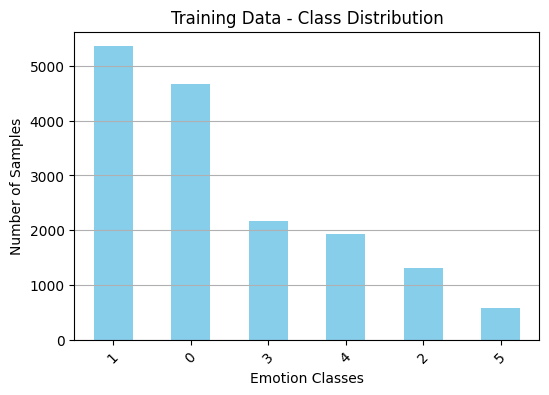

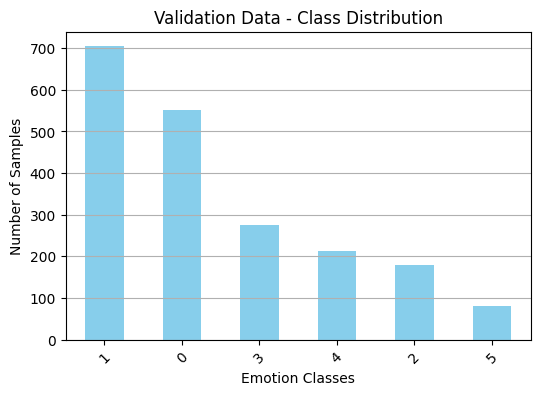

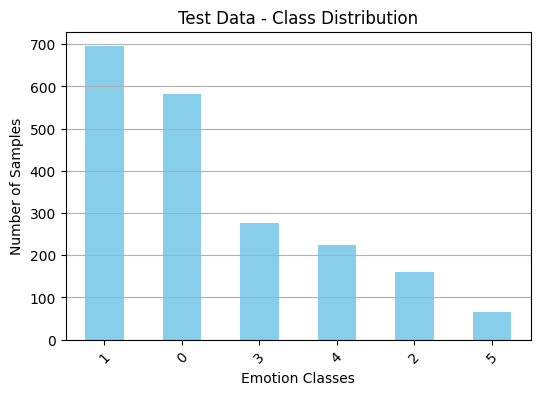

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
df_train = pd.read_csv('/training.csv')
df_val = pd.read_csv('/validation.csv')
df_test = pd.read_csv('/test.csv')


def plot_class_distribution(dataset, title):
    plt.figure(figsize=(6, 4))
    dataset['label'].value_counts().plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel('Emotion Classes')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

# Plot for each dataset
plot_class_distribution(df_train, 'Training Data - Class Distribution')
plot_class_distribution(df_val, 'Validation Data - Class Distribution')
plot_class_distribution(df_test, 'Test Data - Class Distribution')



In [ ]:
def normalize(text):

    text = text.replace("\n", " ").replace("\r", " ")
    text = re.sub(r'\s+', ' ', text)

    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'http\S+', '', text)

    text = text.strip()

    text = re.sub(r'[^a-zA-Z\s]', '', text)

    text = text.lower()
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    text = ' '.join(word for word in word_tokens if word not in stop_words)
    return text

df_train['text'] = df_train['text'].apply(normalize)
df_val['text']   = df_val['text'].apply(normalize)
df_test['text']  = df_test['text'].apply(normalize)


In [ ]:

combined_texts = pd.concat([df_train['text'], df_val['text']], axis=0).values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(combined_texts)


train_sequences = tokenizer.texts_to_sequences(df_train['text'])
val_sequences   = tokenizer.texts_to_sequences(df_val['text'])
test_sequences  = tokenizer.texts_to_sequences(df_test['text'])


max_length = max(len(seq) for seq in train_sequences)
print("Max sequence length (train):", max_length)


X_train = pad_sequences(train_sequences, maxlen=max_length)
X_val   = pad_sequences(val_sequences,   maxlen=max_length)
X_test  = pad_sequences(test_sequences,    maxlen=max_length)

word_index = tokenizer.word_index
num_words  = len(word_index) + 1
print("Vocabulary size:", num_words)


Max sequence length (train): 35
Vocabulary size: 16045


In [ ]:
y_train = pd.get_dummies(df_train['label']).values
y_val   = pd.get_dummies(df_val['label']).values
y_test  = pd.get_dummies(df_test['label']).values

print("y_train shape:", y_train.shape)
print("y_val shape:  ", y_val.shape)
print("y_test shape: ", y_test.shape)


y_train shape: (16000, 6)
y_val shape:   (2000, 6)
y_test shape:  (2000, 6)


In [ ]:
model = Sequential([
    Embedding(num_words, 100, input_length=max_length),
    SpatialDropout1D(0.4),
    LSTM(128, dropout=0.4, recurrent_dropout=0.4),
    Dense(y_train.shape[1], activation='softmax')  # number of classes in y_train
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)



In [ ]:
epochs = 10
batch_size = 32

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    verbose=1
)


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 157ms/step - accuracy: 0.3563 - loss: 1.5673 - val_accuracy: 0.7165 - val_loss: 0.8795
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 86s 164ms/step - accuracy: 0.7666 - loss: 0.7194 - val_accuracy: 0.8915 - val_loss: 0.3123
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 136s 155ms/step - accuracy: 0.9040 - loss: 0.2898 - val_accuracy: 0.9225 - val_loss: 0.2225
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 77s 155ms/step - accuracy: 0.9365 - loss: 0.1824 - val_accuracy: 0.9225 - val_loss: 0.1900
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 155ms/step - accuracy: 0.9530 - loss: 0.1379 - val_accuracy: 0.9240 - val_loss: 0.1819
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 156ms/step - accuracy: 0.9600 - loss: 0.1102 - val_accuracy: 0.9325 - val_loss: 0.1717
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 81s 155ms/step - accuracy: 0.9657 - loss: 0.0921 - val_accuracy: 0.9220 - val_loss: 0.1917
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 85s 162ms/step - accuracy: 0.9746 - loss: 

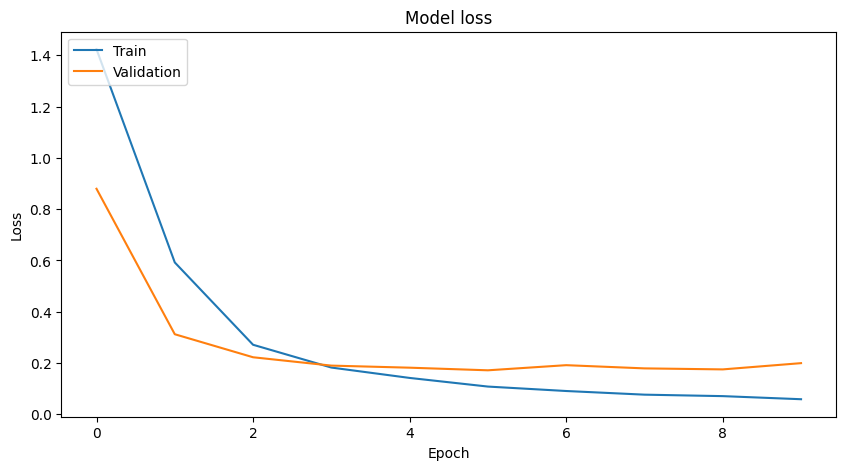

In [ ]:
 #Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



Test Accuracy: 92.75%
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       581
           1       0.95      0.94      0.95       695
           2       0.82      0.81      0.81       159
           3       0.93      0.92      0.93       275
           4       0.90      0.88      0.89       224
           5       0.76      0.80      0.78        66

    accuracy                           0.93      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.93      0.93      0.93      2000



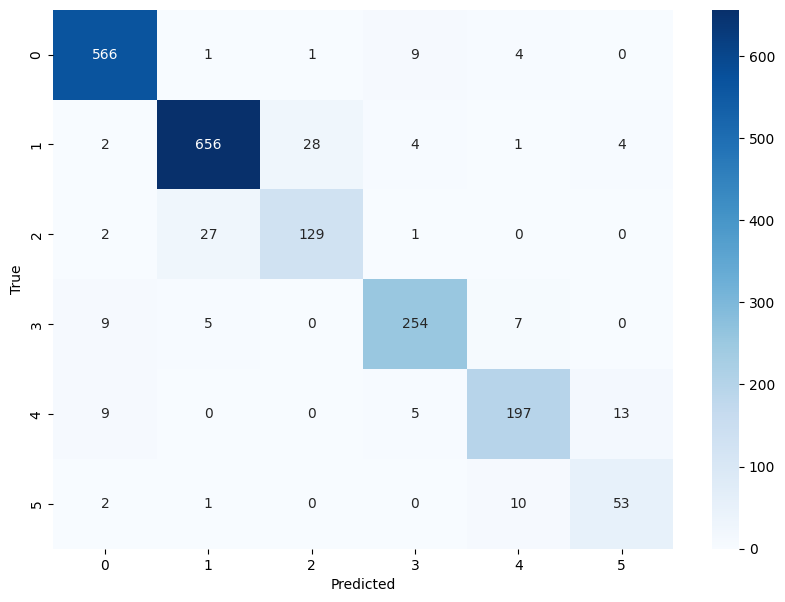

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

from sklearn.metrics import classification_report
y_test_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test_true, y_pred))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Save the trained model
model.save("sa_text.h5")
print("Model saved to sa_text.h5")

import pickle


with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Tokenizer saved to tokenizer.pickle")


with open('max_length.pickle', 'wb') as handle:
    pickle.dump(max_length, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Max length saved to max_length.pickle")


Model saved to sa_text.h5
Tokenizer saved to tokenizer.pickle
Max length saved to max_length.pickle


In [ ]:

label_mapping = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

user_input = input("Enter a text to classify its emotion: ")

normalized_input = normalize(user_input)


input_sequence = tokenizer.texts_to_sequences([normalized_input])


input_padded = pad_sequences(input_sequence, maxlen=max_length)

prediction = model.predict(input_padded)


predicted_numeric_label = np.argmax(prediction, axis=1)[0]


predicted_emotion = label_mapping[predicted_numeric_label]
print("Predicted Emotion:", predicted_emotion)


Enter a text to classify its emotion: i want to kill proffesor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Emotion: anger
